In [1]:
import torch
from torch import nn
from torch.nn import functional
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import utils
import numpy as np
from model import unet,unet_backbone

In [2]:
voc_dir = '../autodl-tmp/data/VOCdevkit/VOC2012'
# train_features, train_labels = utils.read_voc_images(voc_dir)

In [3]:
crop_size = (320, 480)
voc_train = utils.VOCSegDataset(True, crop_size, voc_dir)
voc_test = utils.VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [10]:
batch_size = 64
train_iter = DataLoader(voc_train, batch_size, shuffle=True)
test_iter = DataLoader(voc_test,batch_size,shuffle=False)
# for X, Y in train_iter:
#     print(X.shape[0])

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
channels = 32
classes = 21 # 21 classes
input_channels = 3
model = unet.Unet(input_channels,channels,classes).to(device)
model.apply(utils.init_weights)
# print(model)

Unet(
  (cblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3)

In [8]:
lr = 1e-5
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-3)
# optimizer = torch.optim.SGD(model.parameters(),lr=lr,weight_decay=1e-3)

In [9]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    utils.train(train_iter, device, model, loss_fn, optimizer)
    utils.test(test_iter,device,model,loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.283056  [    0/ 1114]
loss: 1.154785  [  960/ 1114]
Test Error: 
 Accuracy: 72.90%, Avg loss: 1.152793 

Epoch 2
-------------------------------
loss: 0.873868  [    0/ 1114]
loss: 1.124898  [  960/ 1114]
Test Error: 
 Accuracy: 72.90%, Avg loss: 1.153634 

Epoch 3
-------------------------------
loss: 0.910093  [    0/ 1114]
loss: 1.162872  [  960/ 1114]
Test Error: 
 Accuracy: 72.95%, Avg loss: 1.149682 

Epoch 4
-------------------------------
loss: 1.114717  [    0/ 1114]
loss: 1.080390  [  960/ 1114]
Test Error: 
 Accuracy: 72.91%, Avg loss: 1.151493 

Epoch 5
-------------------------------
loss: 1.142090  [    0/ 1114]
loss: 0.777264  [  960/ 1114]
Test Error: 
 Accuracy: 72.92%, Avg loss: 1.151669 

Epoch 6
-------------------------------
loss: 1.034017  [    0/ 1114]
loss: 1.255914  [  960/ 1114]
Test Error: 
 Accuracy: 73.00%, Avg loss: 1.148627 

Epoch 7
-------------------------------
loss: 1.086874  [    0/ 1114]
loss: 1.1928

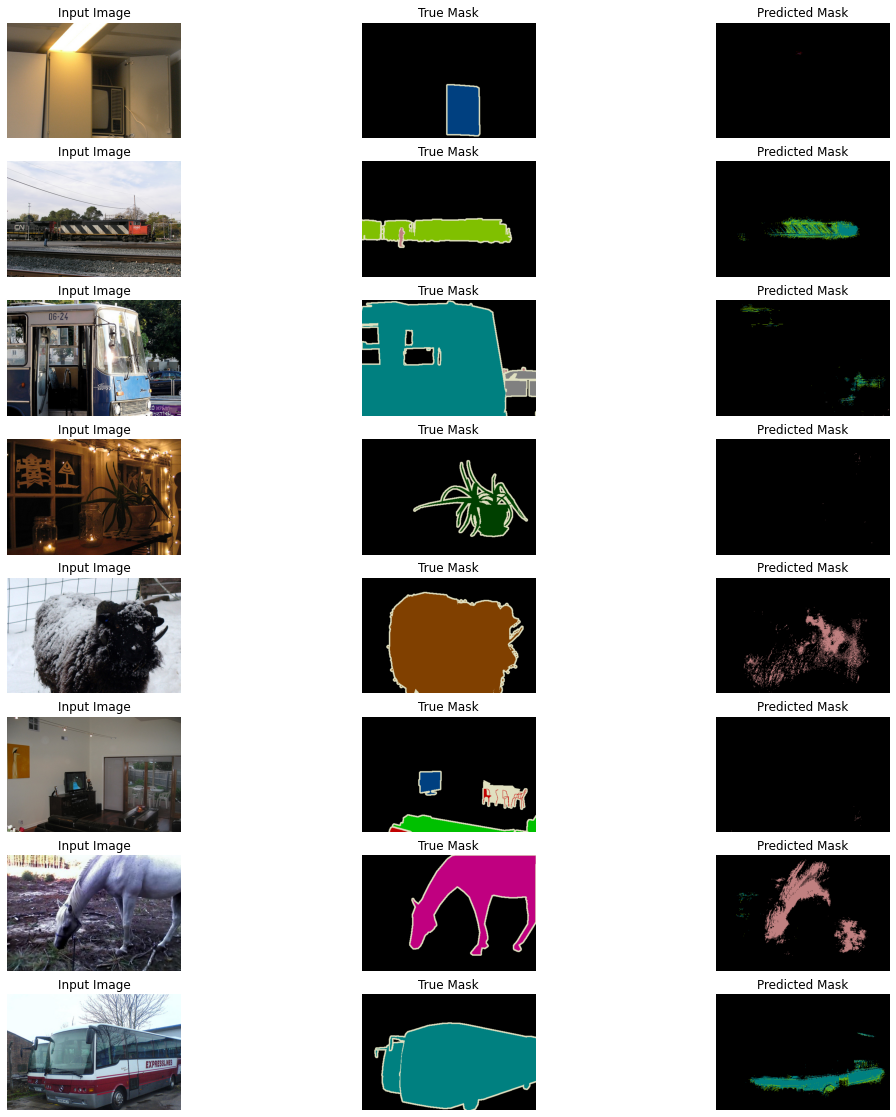

In [12]:
# 裁剪一些图片的一部分进行预测
test_images, test_labels = utils.read_voc_images(voc_dir, False)
n = 8
rows,cols = n,3
title = ['Input Image', 'True Mask', 'Predicted Mask']
plt.figure(figsize=(18, 20))
for i in range(n):
    idx = torch.randint(len(test_images),(1,)).item()
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[idx], *crop_rect)
    pred = utils.label2image(utils.predict(X,test_iter,device,model),device)
    img_list = [X.permute(1,2,0),
                torchvision.transforms.functional.crop(test_labels[idx],*crop_rect).permute(1,2,0),
                pred.cpu()]
    for j,img in enumerate(img_list):
        plt.subplot(rows,cols,i*cols+j+1)
        plt.title(title[j])
        # plt.imshow(transforms.ToPILImage()(img))
        plt.imshow(img.numpy())
        plt.axis('off')
plt.show()

In [13]:
torch.save(model,'Unet-100epochs.pt')

In [7]:
model = torch.load('Unet-50epochs.pt',map_location=device)

In [11]:
# mean iou
model.eval()

mean_iou = []
with torch.no_grad():
    for X,y in test_iter:
        X,y = X.to(device),y.to(device)
        pred = model(X)
        pred = torch.argmax(pred,1)
        iou = utils.iou(pred,y,21,ignore_background=True)
        iou = np.mean(iou)
        mean_iou.append(iou)
        print(f'this mean iou is :{iou}')
print(f'mean iou for all is: {np.mean(mean_iou)}')

this mean iou is :0.004755018365883439
this mean iou is :0.007881926055654652
this mean iou is :0.006622146903399144
this mean iou is :0.013481528516696716
this mean iou is :0.059476216100408014
this mean iou is :0.010384321578137094
this mean iou is :0.006057394137721735
this mean iou is :0.008589771578131284
this mean iou is :0.0051552940965662215
this mean iou is :0.010126382728362174
this mean iou is :0.053862803172780124
this mean iou is :0.004521136213255705
this mean iou is :0.008495691153128074
this mean iou is :0.006321947703003654
this mean iou is :0.008129900717437173
this mean iou is :0.053142044012646765
this mean iou is :0.005203729085064976
mean iou for all is: 0.016012191301075115
